In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Welcome to gingado!

> A machine learning library for economics and finance

The purpose of `gingado` is to support usage of machine learning models in economics and finance use cases, promoting good modelling practices while being easy to use. `gingado` aims to be suitable for beginners and advanced users alike.

Most functionalities are likely to also be useful to a broader set of users. In addition to more general benefits, `gingado` is designed to align well with the workflow needs of economists due to its support for panel datasets and the functionality to quickly and easily add official statistical data on macroeconomics and finance to the user dataset.

## Install

To install `gingado`, simply run the following code on the terminal:

`$ pip install gingado`

## Overview

`gingado` is built around three main functionalities:
* **data augmentation**, to add more data from official sources, improving the machine models being trained by the user;
* **automatic benchmark model**, to enable the user to assess their models against a reasonably well-performant model; and
* **support for model documentation**, to embed documentation and ethical considerations in the model development phase.

Each of these functionalities is illustrated below for a user trying to forecast GDP growth. Each step builds on top of the previous one, and they can be used stand-alone, together, or even as part of a larger pipeline from data input to model training to documentation! But to highlight how `gingado` can benefit users in multiple ways, the brief walk-through below goes over them separtely and then highlights how they can work jointly. 

Before stepping in, let's import the necessary packages and data.

### Setup

This walk-through will use the [Jordà-Schularick-Taylor Macrohistory Database](https://www.macrohistory.net) on macroeconomics and finance as an example. As a preliminary step, let's import `gingado` and other necessary libraries, and proceed to download the data:

In [ ]:
import pandas as pd

JST_url = "http://data.macrohistory.net/JST/JSTdatasetR5.dta"
jst = pd.read_stata(JST_url, iterator=False)

jst.tail()

For practical purposes, let's use for this database only the information from 2011 onwards:

In [ ]:
jst.drop(labels=['iso', 'ifs', 'crisisJST_old'], axis=1, inplace=True)
jst['year'] = pd.to_datetime(jst['year'], format='%Y')

start_year = '2011-01-01'
end_year = '2016-01-01'
jst = jst[jst['year'] >= start_year]

jst.set_index(['year', 'country'], inplace=True)

In [ ]:
jst.tail()

### Data augmentation

As we can see, the dataset contains mainly information on the GDP of other countries. There are many ways in which this dataset can be complement by a richer set of variables. For example, for the same time periods we can add detailed information on trade, inflation, labour markets, foreign currency exchange rates, and many other series that would help machine learning models better form predictions. 

`gingado` helps this step by facilitating *data augmentation*, ie complementing the user dataset with compatible data. `gingado` only sources data from official data sources, namely statistical agencies, central banks, and other relevant authorities at the domestic or international level.

In particular, `gingado`'s function `augm_with_sdmx` looks for all data available from the desired sources for the defined period and frequency and downloads them all, but only adds to the original dataset the variables that bring some level of variance in the data that can be explored by the machine learning models later on.

In [ ]:
from gingado.augmentation import augm_with_sdmx

jst_augm_gingado = augm_with_sdmx(jst, start_year, end_year, time_col='year', freq='A', sources='BIS')

### Automatic benchmark

Creating a model card can be facilitated by using the template. Upon creation, two informations are already filled by gingado...

## Design principles

The choices made during development of `gingado` derive from the following principles, in no particular order:
* *lowering the barrier to use machine learning* can help more economists familiarise themselves with these techniques and use them when appopriate
* *promoting good practices* such as documenting ethical considerations and benchmarking models as part of machine learning development will help embed these habits in economists
* *offering compatibility with other existing software that is consolidated by wide practice* benefits users and should be promoted as much as possible

## Start-to-end usage example of `gingado`

Let's use `gingado` to implement a machine learning model that seeks to predict multiple exchange rates at the same time. 

### Obtaining the data

The main dataset of interest is the EUR exchange rate against a set of other currencies. It is obtainable from the European Central Bank. Let's download the data using the SDMX protocol to ensure we are using trusted data from the official source and according to a definition that is compatible with the needs of this walk-through. If you are more particularly interested in the use of `gingado` to a dataset that is already downloaded, please proceed to the next section.

If you want to know more about how you can use SDMX with python, or understand the details of this particular data request, consider visiting the [pandasdmx documentation](https://pandasdmx.readthedocs.io/en/v1.0/walkthrough.html). Note that this particular dataset was selected to illustrate this section because it is the similar to the example in the `pandasdmx` documentation, so that readers can refer to that material if more detail is needed.

In [ ]:
import pandasdmx as sdmx
ecb = sdmx.Request('ECB')
flow_msg = ecb.dataflow()

In [ ]:
exr_msg = ecb.dataflow('EXR')
exr_flow = exr_msg.dataflow.EXR
dsd = exr_flow.structure

In [ ]:
key = {
    "CURRENCY": ['EUR', 'AUD', 'BRL', 'CAD', 'CHF', 'GBP', 'JPY', 'SGD', 'USD'],
    "FREQ": 'D'
}

params = {"startPeriod": '2003'}

In [ ]:
data_msg = ecb.data('EXR', key=key, params=params, dsd=dsd)
EUR_FX = sdmx.to_pandas(data_msg.data[0], datetime='TIME_PERIOD')

The variable EUR_FX holds the data we want. The following lines remove index levels that are single-valued (and thus do not differentiate groups of observations), and pivots the data so that each exchange rate against the EUR is located in its own column.

In [ ]:
EUR_FX = EUR_FX.droplevel(['FREQ', 'CURRENCY_DENOM', 'EXR_TYPE', 'EXR_SUFFIX'], axis=1).dropna()

Before proceeding, let's plot the series to confirm that they were downloaded properly, and also to get a visual idea of how they vary over time.

array([[<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>]], dtype=object)

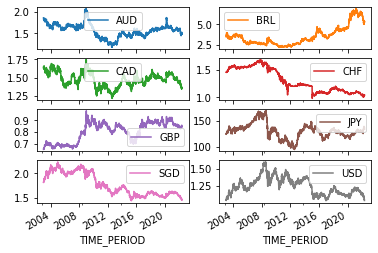

In [ ]:
EUR_FX.plot(subplots=True, layout=(4, 2))

### `gingado`'s first contribution: Augmenting data

The user now might want to add more data to the original dataset. This would offer the machine learning model a more rich set of inputs from which to uncover relationships that will help better predict the dataset of interest.

`gingado` helps the user augment its original dataset using the SDMX to fetch relevant data from official sources. But first, let's do it step by step.

#### Preliminaries
This phase entails importing the necessary libraries and defining the source(s), frequency and starting period for the statistical data to be downloaded.

In [ ]:
import pandas as pd
import pandasdmx as sdmx
from sklearn.feature_selection import VarianceThreshold

sources = ['ECB']
key = {"FREQ": 'D'}

params = {"startPeriod": '2003-01-01'}

#### Downloading the additional data

During this step, the information is sought after from the official sources, and added to the original dataset provided by the user.

In [ ]:
data_sdmx = {}
for source in sources:
    src_conn = sdmx.Request(source, backend='memory', expire_after=1800)
    src_dflows = src_conn.dataflow()
    dflows = {k: v for k, v in src_dflows.dataflow.items()}
    for dflow in dflows.keys():
        print(f"Trying to download data from {source}'s dataflow {dflow}...")
        try:
            data = sdmx.to_pandas(src_conn.data(dflow, key=key, params=params), datetime='TIME_PERIOD')
        except:
            print("this dataflow does not have data in the desired frequency and time period.")
            continue
        data.columns = ['_'.join(col) for col in data.columns.to_flat_index()]
        data_sdmx[source+"_"+dflow] = data
df = pd.concat(data_sdmx, axis=1)
df.columns = ['_'.join(col) for col in df.columns.to_flat_index()]

#### Cleaning the augmented dataset

It is plausible that some of the newly downloaded data might not be useful for the user. For example, they might not vary during the desired time period, or they might be collinear to the original dataset provided by the user. So this step entails removing any instances where this occurs in the augmented dataset.

In [ ]:
variance_threshold = None

feat_sel = VarianceThreshold() if variance_threshold is None else VarianceThreshold(threshold=variance_threshold)
feat_sel.fit(df)
    
features_stay_ = df.columns[feat_sel.get_support()]
features_removed_ = df.columns[~feat_sel.get_support()]

df = df.iloc[:, feat_sel.get_support()]

#### Merging the new dataset with the original dataset

The original dataset is now augmented by additional data. One last check is done before handing it over again to the user, to confirm that the newly added data is not collinear to any of the columns of the original dataset. (TODO)

In [ ]:
augm_df = pd.concat([EUR_FX.dropna(), df], axis=1, join='inner')

,AUD,BRL,CAD,CHF,GBP,JPY,SGD,USD,ECB_CISS_D_AT_Z0Z_4F_EC_SS_CIN_IDX,ECB_CISS_D_BE_Z0Z_4F_EC_SS_CIN_IDX,...,ECB_RDE_D_D0_Z0Z_DE_EC_SRCB_COVAR_95P,ECB_RDE_D_D0_Z0Z_DE_EC_SRCB_COVAR_AVE,ECB_RDE_D_D0_Z0Z_DE_EC_SRCI_COVAR_5P,ECB_RDE_D_D0_Z0Z_DE_EC_SRCI_COVAR_95P,ECB_RDE_D_D0_Z0Z_DE_EC_SRCI_COVAR_AVE,ECB_RDF_D_D0_Z0Z_4F_EC_DFTLB_PR,ECB_RDF_D_U2_Z0Z_4F_EC_U2_CEB_HST,ECB_RDF_D_U2_Z0Z_4F_EC_U2_CI_HST,ECB_RDF_D_U2_Z0Z_4F_EC_U2_GRAI_HST,ECB_RDF_D_U2_Z0Z_4F_EC_U2_MM_HST
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2003-01-02,1.8554,3.6770,1.6422,1.4528,0.65200,124.40,1.8188,1.0446,0.023427,0.047823,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,-0.42,1.17,0.08
2003-01-03,1.8440,3.6112,1.6264,1.4555,0.65000,124.56,1.8132,1.0392,0.021899,0.043292,...,-0.008989,-0.078866,-0.178504,-0.04966,-0.112854,NaN,-0.48,-0.40,1.04,0.08
2003-01-06,1.8281,3.5145,1.6383,1.4563,0.64950,124.40,1.8210,1.0488,0.020801,0.039924,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,-0.36,0.78,0.11
2003-01-07,1.8160,3.5139,1.6257,1.4565,0.64960,124.82,1.8155,1.0425,0.019738,0.038084,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.45,-0.34,0.61,0.11
2003-01-08,1.8132,3.4405,1.6231,1.4586,0.64950,124.90,1.8102,1.0377,0.019947,0.040338,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.43,-0.30,0.90,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,1.5048,5.4321,1.3656,1.0462,0.85235,138.10,1.4676,1.0559,0.236760,0.112418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-10,1.5162,5.4232,1.3707,1.0479,0.85595,137.38,1.4667,1.0554,0.256625,0.130420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-11,1.5055,5.3859,1.3685,1.0446,0.85393,137.07,1.4622,1.0553,0.250490,0.128284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
